# **Importing Libraries and Loading Dataset**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Loading the dataset again because the pretrained network assumes the pixels range from 0 ~ 255.
(X_trainfull, y_trainfull), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Splitting the trainfull set into train and validation set
X_train, X_valid = X_trainfull[:-5_000], X_trainfull[-5_000:]
y_train, y_valid = y_trainfull[:-5_000], y_trainfull[-5_000:]

170498071/170498071 [==============================] - 3s 0us/step


In [3]:
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# **ResNet50 Preprocessing and Model Building**

In [4]:


# Preprocessing for ResNet50 model
def preprocess_ResNet50_input(input_images):
    input_images = input_images.astype('float32')
    preprocessed_images = keras.applications.resnet50.preprocess_input(input_images)
    return preprocessed_images

# Applying the preprocessing function
X_train_processed = preprocess_ResNet50_input(X_train)
X_valid_processed = preprocess_ResNet50_input(X_valid)
X_test_processed = preprocess_ResNet50_input(X_test)

# Building the ResNet50 model
def BuildModel():
    inputs = keras.layers.Input(shape=(32, 32, 3))
    resized = keras.layers.UpSampling2D(size=(7, 7))(inputs)
    base_model = keras.applications.resnet50.ResNet50(input_shape=[224, 224, 3], include_top=False, weights='imagenet')(resized)
    avg = keras.layers.GlobalAveragePooling2D()(base_model)
    Flatten = keras.layers.Flatten()(avg)
    dense1 = keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(Flatten)
    dense2 = keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(dense1)
    output = keras.layers.Dense(10, activation='softmax')(dense2)
    model_pre = keras.Model(inputs=[inputs], outputs=[output])
    return model_pre

keras.backend.clear_session()

# Creating and compiling the ResNet50 model
model_pre = BuildModel()

# Fine-tuning the model
# Unfreeze the layers for fine-tuning
for layer in model_pre.layers[100:]:
    layer.trainable = True

# Compile the model for fine-tuning
model_pre.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.SGD())

# Callback for ResNet50 model
Checkpoint_cb_resnet = keras.callbacks.ModelCheckpoint("save1.keras", save_best_only=True, monitor='val_accuracy', mode='max')
Earlystopping_cb_resnet = keras.callbacks.EarlyStopping(patience=3)
callback1 = [Checkpoint_cb_resnet, Earlystopping_cb_resnet]




94765736/94765736 [==============================] - 1s 0us/step


# **ResNet50 Evaluation**

In [5]:
# Fine-tune the model
history_fine_tune = model_pre.fit(X_train_processed, y_train, batch_size=64,
                                  validation_data=(X_valid_processed, y_valid),
                                  epochs=30, callbacks = callback1)


# Loading the best model
best_model_pre = load_model("save1.keras")

# Evaluate the fine-tuned model
test_loss, test_accuracy = best_model_pre.evaluate(X_valid_processed, y_valid, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/30
704/704 [==============================] - 513s 683ms/step - loss: 0.3993 - accuracy: 0.8673 - val_loss: 0.3316 - val_accuracy: 0.8886
Epoch 2/30
704/704 [==============================] - 477s 677ms/step - loss: 0.0973 - accuracy: 0.9680 - val_loss: 0.1521 - val_accuracy: 0.9498
Epoch 3/30
704/704 [==============================] - 482s 684ms/step - loss: 0.0319 - accuracy: 0.9912 - val_loss: 0.1725 - val_accuracy: 0.9474
Epoch 4/30
704/704 [==============================] - 482s 685ms/step - loss: 0.0133 - accuracy: 0.9968 - val_loss: 0.2041 - val_accuracy: 0.9432
Epoch 5/30
704/704 [==============================] - 488s 693ms/step - loss: 0.0068 - accuracy: 0.9987 - val_loss: 0.1834 - val_accuracy: 0.9528
157/157 - 18s - loss: 0.1834 - accuracy: 0.9528 - 18s/epoch - 113ms/step
Test Loss: 0.1834
Test Accuracy: 0.9528


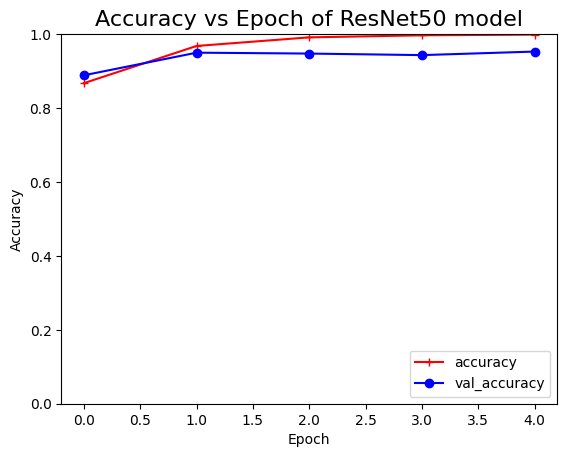

In [26]:
# Plotting accuracy over epochs
plt.plot(history_fine_tune.history['accuracy'], 'r+-', label='accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], 'bo-', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy vs Epoch of ResNet50 model", fontsize=16)
plt.ylim([0, 1])
plt.legend(loc='lower right')
# Save the plot to a file (e.g., in PNG format)
plt.savefig('accuracy_vs_epoch_resnet50.png')
plt.show()

In [7]:
# Setting suppress to True to obtain float numbers instead of scientific notation
np.set_printoptions(suppress=True)

# Predictions
pred = best_model_pre.predict(X_valid_processed)
y_pred = np.argmax(pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

157/157 [==============================] - 16s 95ms/step
Confusion Matrix:
[[463   2   7   3   2   1   1   2   8   4]
 [  0 477   0   0   0   1   0   0   0  10]
 [  3   0 456   7   8   1   3   1   0   0]
 [  1   0   6 458   9  31  12   1   0   1]
 [  0   0   3   3 460   1   5   3   0   0]
 [  0   0   2  25   4 493   3   2   0   0]
 [  0   1   1   2   1   1 482   0   0   0]
 [  1   0   2   6   9   6   1 459   0   1]
 [  4   2   2   0   1   0   0   0 515   8]
 [  0   9   1   1   0   0   0   0   0 501]]


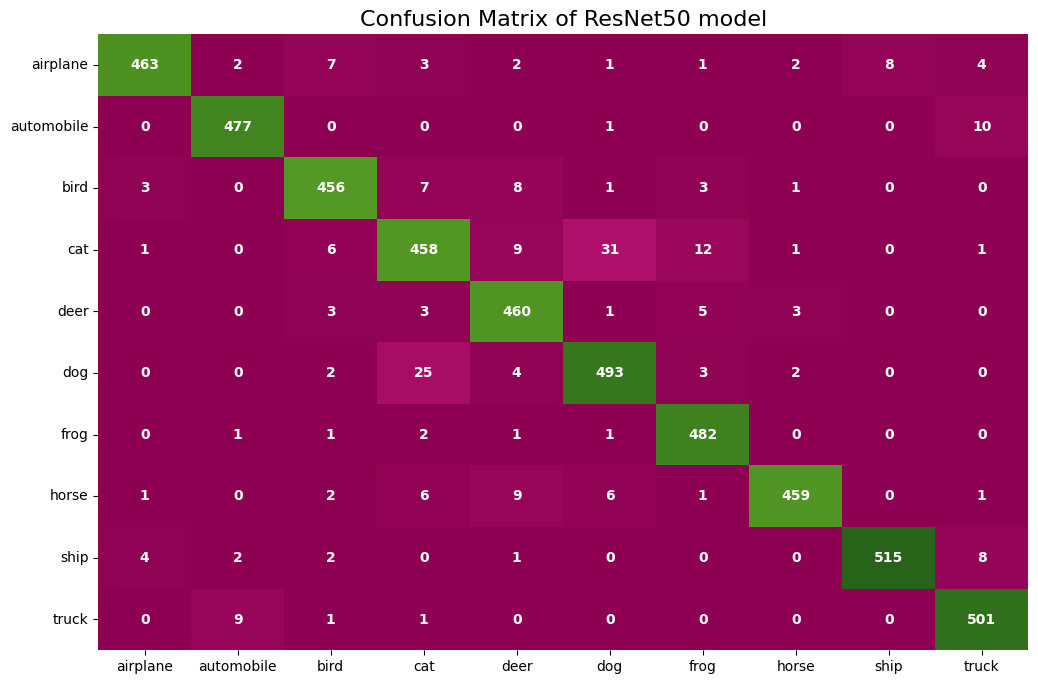

In [27]:
# Plotting the confusion matrix using seaborn's heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, cmap='PiYG', annot=True, fmt='.0f', cbar=False,
            annot_kws={'weight': 'bold'},
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix of ResNet50 model", fontsize=16)
# Save the plot to a file
plt.savefig('Confusion Matrix resnet50.png')
plt.show()

In [9]:
# Classification report
print(classification_report(y_valid, y_pred, target_names=label_names))


              precision    recall  f1-score   support

    airplane       0.98      0.94      0.96       493
  automobile       0.97      0.98      0.97       488
        bird       0.95      0.95      0.95       479
         cat       0.91      0.88      0.89       519
        deer       0.93      0.97      0.95       475
         dog       0.92      0.93      0.93       529
        frog       0.95      0.99      0.97       488
       horse       0.98      0.95      0.96       485
        ship       0.98      0.97      0.98       532
       truck       0.95      0.98      0.97       512

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



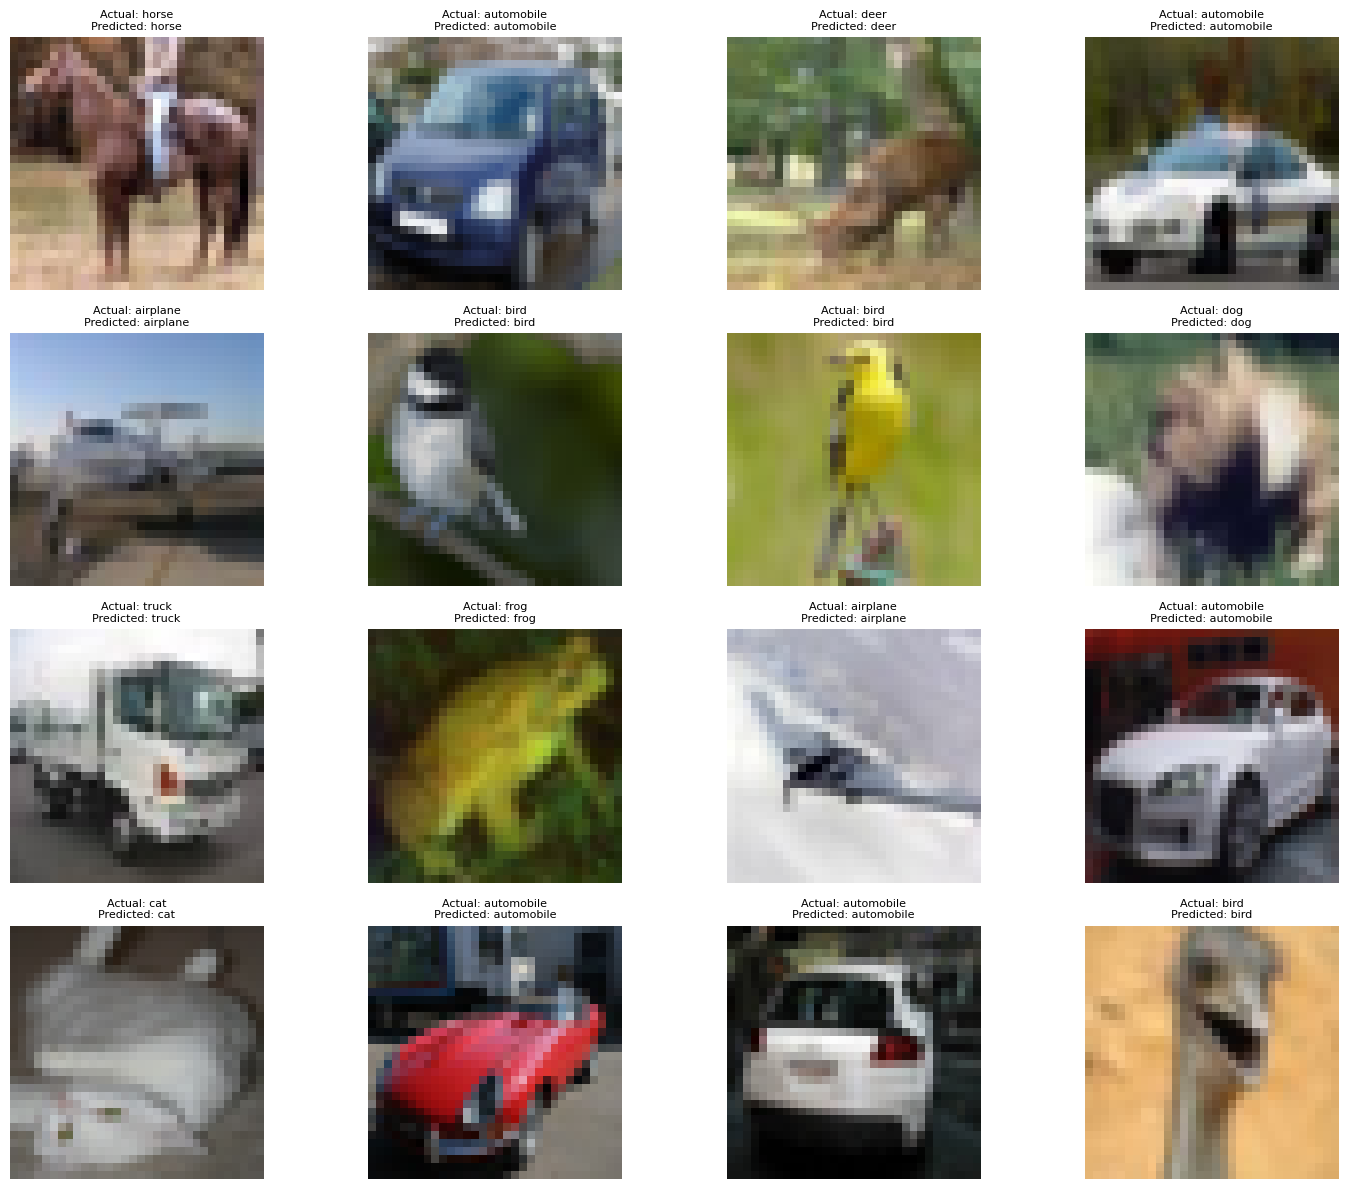

In [46]:
plt.figure(figsize=(15,12))
for i in range (16):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_valid[i])
    plt.title(f"Actual: {np.array(label_names)[y_valid[i]]}\nPredicted: {np.array(label_names)[y_pred[i]]}", fontsize = 8)
    plt.axis("off")
# Save the plot to a file
plt.tight_layout()
plt.savefig('prediction_visualization_resnet50.png')
plt.show()

# **Data Scaling and Conversion for Custom CNN**

In [11]:
# Scaling the data
X_train = X_train / 255.
X_valid = X_valid / 255.
X_test = X_test / 255.

# Converting the target values to 1 dimension
y_train = y_train.ravel()
y_valid = y_valid.ravel()
y_test = y_test.ravel()

# Converting target values to Categorical
y_train_cat = to_categorical(y_train, 10)
y_valid_cat = to_categorical(y_valid, 10)
y_test_cat = to_categorical(y_test, 10)

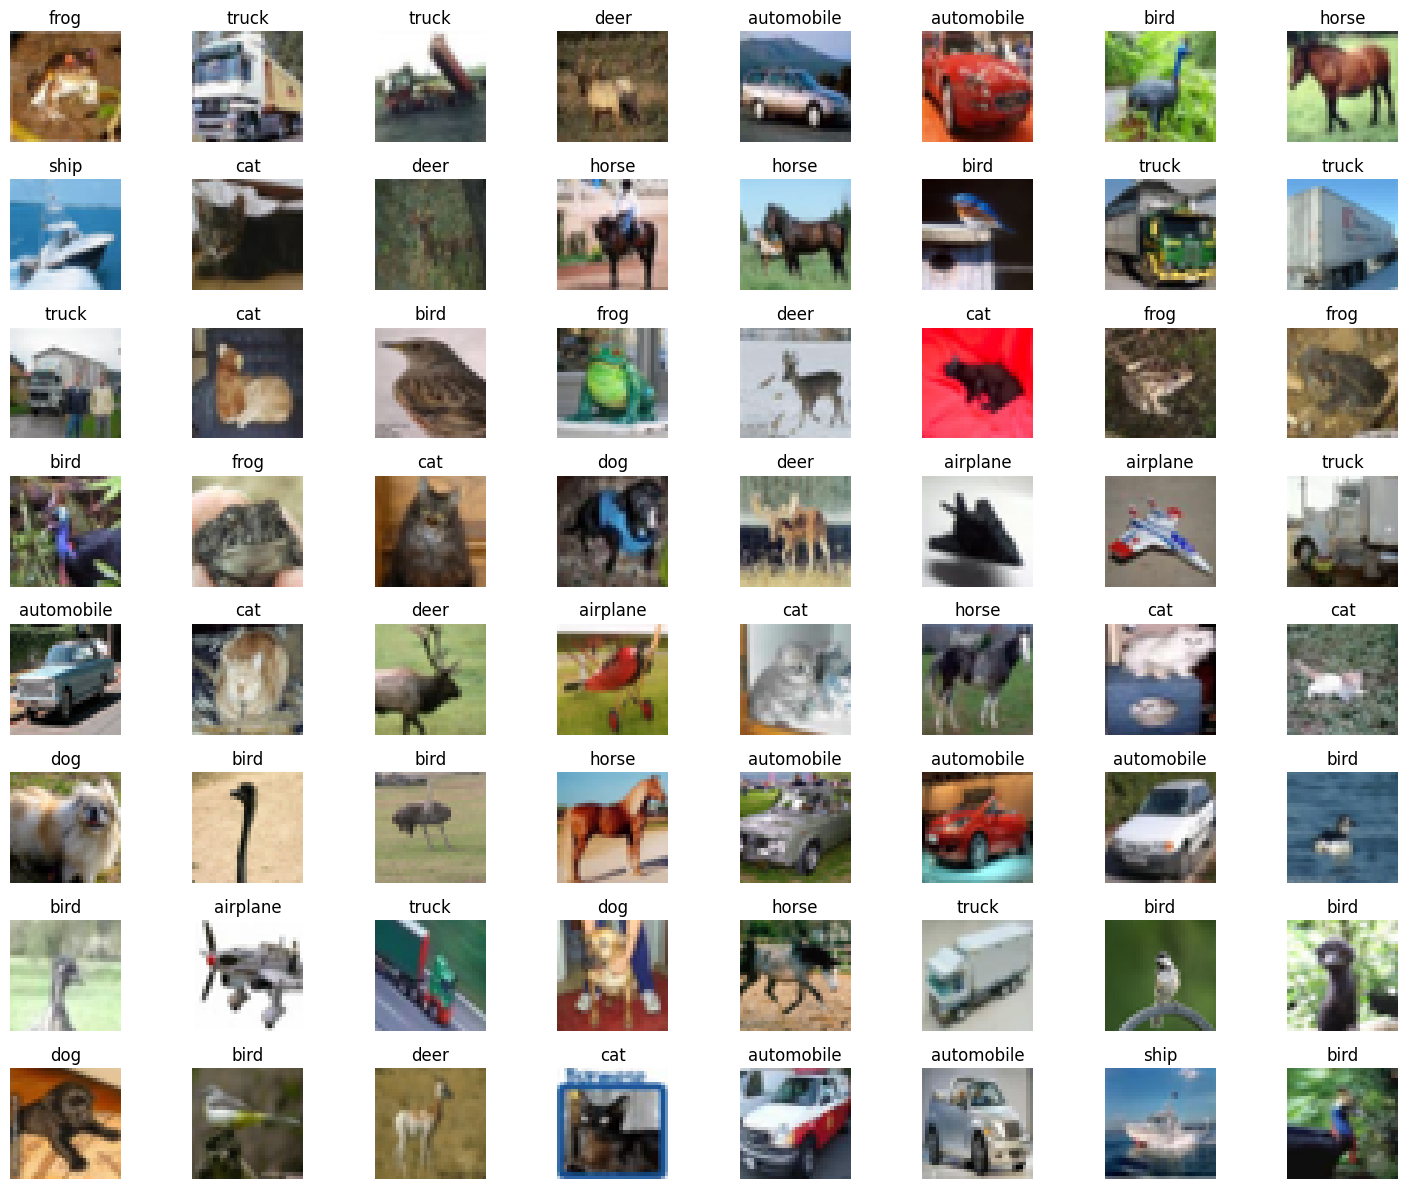

In [12]:
# Visualizing some training samples
plt.figure(figsize=(15, 12))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(X_train[i])
    plt.title(np.array(label_names)[y_train[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

# **Custom CNN Model Architecture**

In [13]:
from functools import partial

# setting a random seed for reproducibilty of results
np.random.seed(42)
tf.random.set_seed(42)

keras.backend.clear_session()

# Creating a Default convolutional layer
DefaultConv = partial(keras.layers.Conv2D, strides=1, kernel_size=3, padding='same', activation='relu')

# Building the model
model = keras.models.Sequential([
    DefaultConv(filters=32, input_shape=[32, 32, 3]),
    keras.layers.BatchNormalization(),
    DefaultConv(filters=32, kernel_size=5),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dropout(0.2),

    DefaultConv(filters=64),
    keras.layers.BatchNormalization(),
    DefaultConv(filters=64),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dropout(0.3),

    DefaultConv(filters=128),
    keras.layers.BatchNormalization(),
    DefaultConv(filters=128),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal', use_bias=False),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax'),
])

model.summary()

model.compile(loss="categorical_crossentropy", metrics=['accuracy'],
              optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        25632     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

# **Custom CNN Evaluation**

In [14]:
# Callbacks
Checkpoint_cb = keras.callbacks.ModelCheckpoint("save.keras", save_best_only=True, monitor='val_accuracy', mode='max')
Earlystopping_cb = keras.callbacks.EarlyStopping(patience=10)
callback = [Checkpoint_cb, Earlystopping_cb]



In [15]:
# Training the model
history = model.fit(X_train, y_train_cat, epochs = 100,
                    batch_size=30,
                    validation_data = (X_valid, y_valid_cat),
                    callbacks=callback)

Epoch 1/100
1500/1500 [==============================] - 18s 9ms/step - loss: 1.9570 - accuracy: 0.2787 - val_loss: 1.6231 - val_accuracy: 0.3980
Epoch 2/100
1500/1500 [==============================] - 12s 8ms/step - loss: 1.6080 - accuracy: 0.4033 - val_loss: 1.3150 - val_accuracy: 0.5132
Epoch 3/100
1500/1500 [==============================] - 12s 8ms/step - loss: 1.4483 - accuracy: 0.4684 - val_loss: 1.1903 - val_accuracy: 0.5664
Epoch 4/100
1500/1500 [==============================] - 12s 8ms/step - loss: 1.3262 - accuracy: 0.5192 - val_loss: 1.3531 - val_accuracy: 0.5326
Epoch 5/100
1500/1500 [==============================] - 12s 8ms/step - loss: 1.2215 - accuracy: 0.5609 - val_loss: 0.9897 - val_accuracy: 0.6512
Epoch 6/100
1500/1500 [==============================] - 12s 8ms/step - loss: 1.1444 - accuracy: 0.5915 - val_loss: 0.9742 - val_accuracy: 0.6472
Epoch 7/100
1500/1500 [==============================] - 12s 8ms/step - loss: 1.0908 - accuracy: 0.6122 - val_loss: 0.9228 -

In [16]:
# Loading the best model
best_model = load_model("save.keras")

# Evaluating the model on validation data
test_loss, test_accuracy = best_model.evaluate(X_valid, y_valid_cat, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

157/157 - 1s - loss: 0.4528 - accuracy: 0.8600 - 1s/epoch - 9ms/step
Test Loss: 0.4528
Test Accuracy: 0.8600


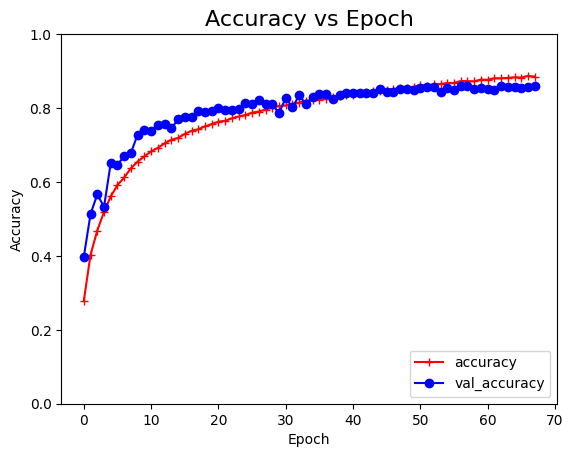

In [30]:
# Plotting accuracy over epochs
plt.plot(history.history['accuracy'], 'r+-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'bo-', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy vs Epoch", fontsize=16)
plt.ylim([0, 1])
plt.legend(loc='lower right')
# Save the plot to a file
plt.savefig('accuracy_over_epochs_scratch.png')

plt.show()


In [18]:
# Setting suppress to True to obtain float numbers instead of scientific notation
np.set_printoptions(suppress=True)

# Predictions
pred_1 = model.predict(X_valid)
y_pred_1 = np.argmax(pred_1, axis=1)

# Confusion matrix
conf_matrix_1 = confusion_matrix(y_valid_cat.argmax(axis=1), y_pred_1)
print("Confusion Matrix:")
print(conf_matrix_1)

157/157 [==============================] - 1s 3ms/step
Confusion Matrix:
[[417   2  14   9   5   0   4   3  26  13]
 [  2 447   0   0   0   0   3   1  15  20]
 [ 19   0 378  17  28  10  21   5   1   0]
 [  6   1  13 397  15  45  26  10   1   5]
 [  3   0  15  14 410   6  12  11   3   1]
 [  2   1  16  88  13 378   9  21   0   1]
 [  1   1   6  17   5   3 453   0   1   1]
 [  0   0   8  23  15  14   1 419   1   4]
 [  9   5   3   0   1   0   0   1 507   6]
 [  2   9   1   2   1   0   2   0   9 486]]


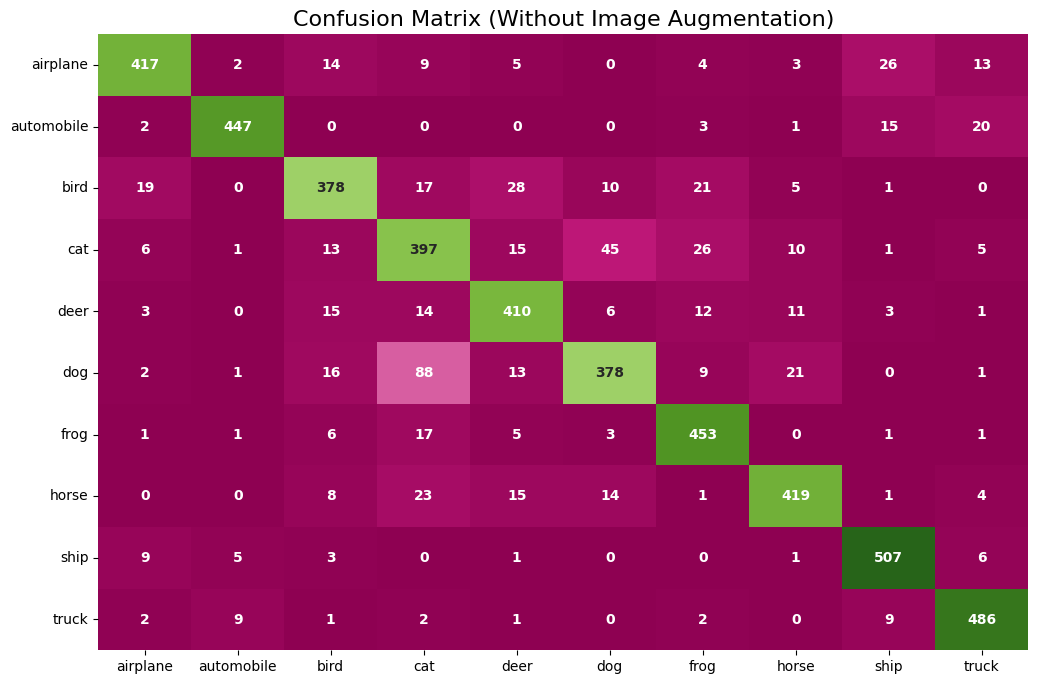

In [31]:
# Plotting the confusion matrix using seaborn's heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_1, cmap='PiYG', annot=True, fmt='.0f', cbar=False,
            annot_kws={'weight': 'bold'},
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix (Without Image Augmentation)", fontsize=16)
plt.savefig('Confusion Matrix scratch.png')
plt.show()

In [20]:

# Classification report
print(classification_report(y_valid_cat.argmax(axis=1), y_pred_1, target_names=label_names))

              precision    recall  f1-score   support

    airplane       0.90      0.85      0.87       493
  automobile       0.96      0.92      0.94       488
        bird       0.83      0.79      0.81       479
         cat       0.70      0.76      0.73       519
        deer       0.83      0.86      0.85       475
         dog       0.83      0.71      0.77       529
        frog       0.85      0.93      0.89       488
       horse       0.89      0.86      0.88       485
        ship       0.90      0.95      0.93       532
       truck       0.91      0.95      0.93       512

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



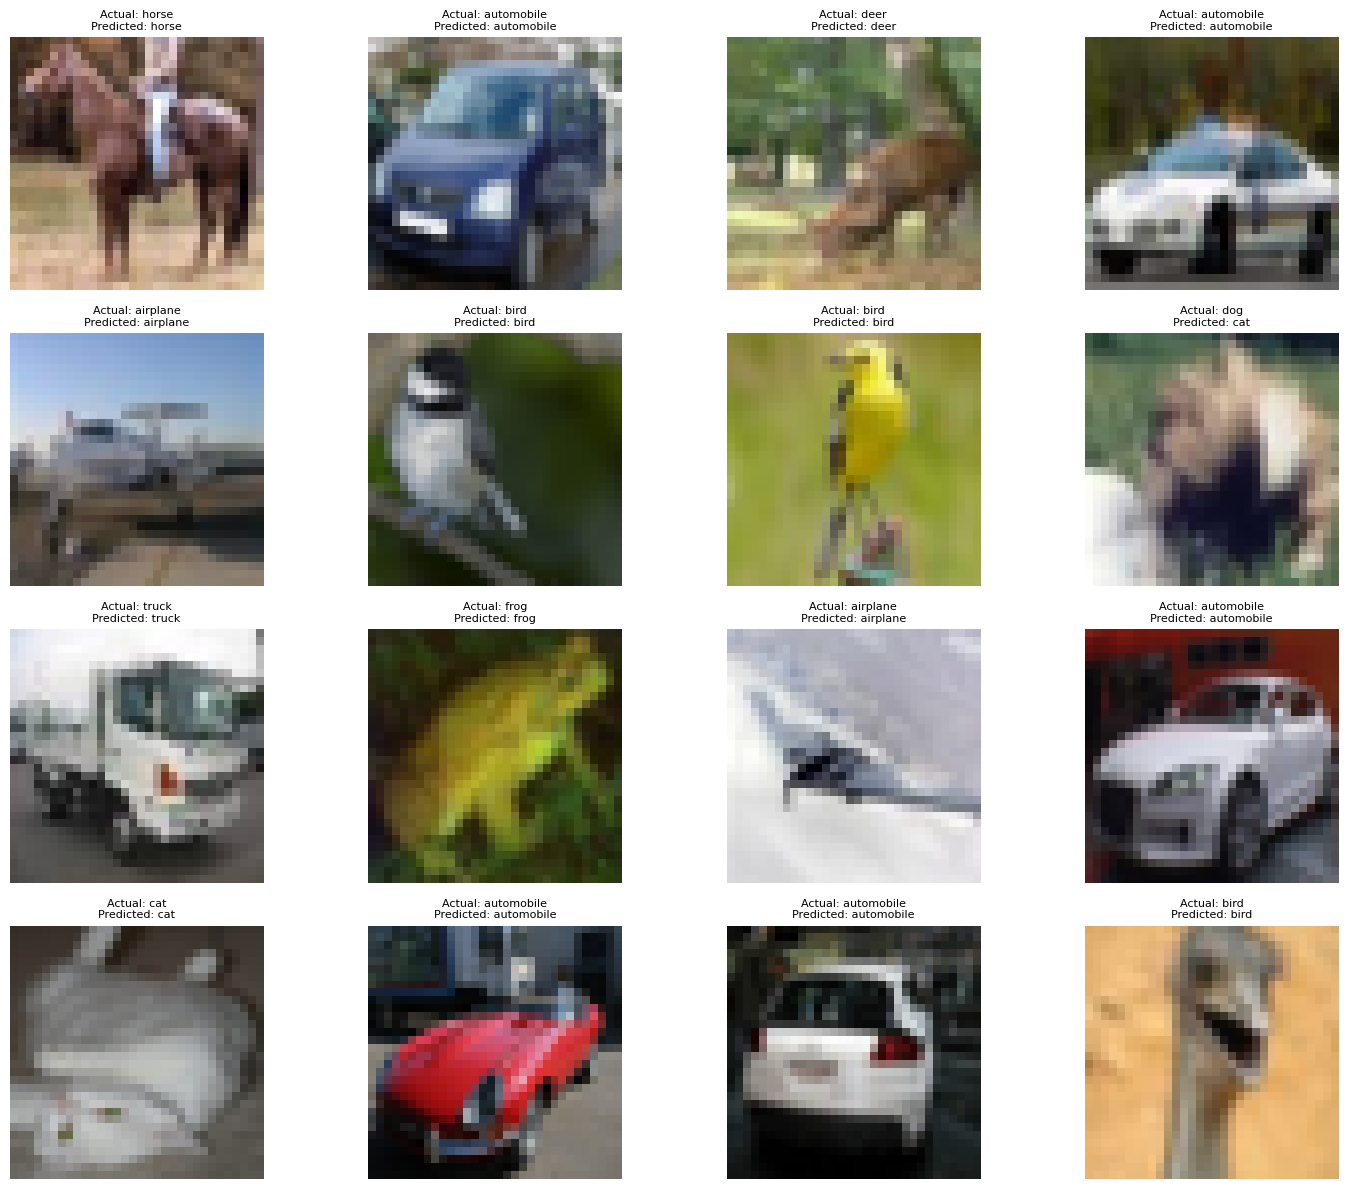

In [47]:
# Visualization of some test samples
plt.figure(figsize=(15, 12))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_valid[i])
    plt.title(f"Actual: {np.array(label_names)[y_valid_cat.argmax(axis=1)[i]]}\nPredicted: {np.array(label_names)[y_pred_1[i]]}", fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.savefig('prediction_visualization_scratch.png')
plt.show()

# **Model Comparison and Analysis**

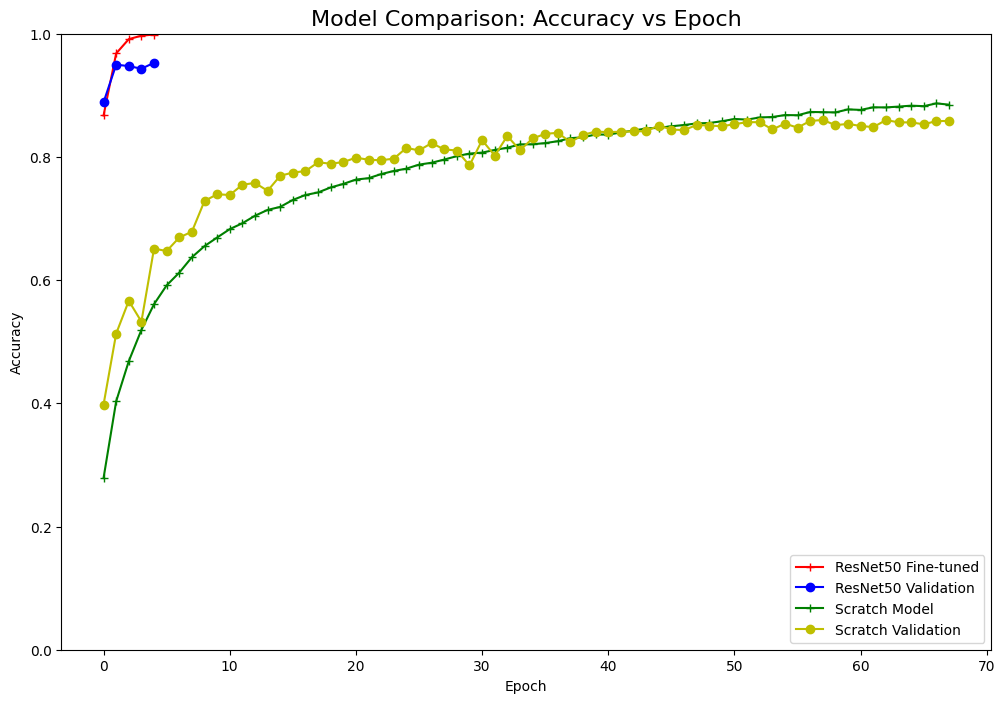

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(history_fine_tune.history['accuracy'], 'r+-', label='ResNet50 Fine-tuned')
plt.plot(history_fine_tune.history['val_accuracy'], 'bo-', label='ResNet50 Validation')
plt.plot(history.history['accuracy'], 'g+-', label='Scratch Model')
plt.plot(history.history['val_accuracy'], 'yo-', label='Scratch Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Model Comparison: Accuracy vs Epoch", fontsize=16)
plt.ylim([0, 1])
plt.legend(loc='lower right')
# Save the plot to a file
plt.savefig('model_comparison_accuracy_over_epochs.png')
plt.show()